## Exercise - Black’s Formula for Options on Futures

In [1]:
import warnings

import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
# Path to the Excel file containing SOFR futures option data
data_path_futures_options = "../data/option_data_bb_SFRZ5.xlsx"
data_path_historical_ref_rates = "../data/ref_rates.xlsx"

# Read the first sheet of the Excel file into a DataFrame
spot = (
    pd.read_excel(data_path_futures_options, sheet_name=0)
    .rename(columns={"Unnamed: 0": "field"})
    .set_index("field")
)

# Read the second sheet of the Excel file into a DataFrame
historical_ref_rates = pd.read_excel(data_path_historical_ref_rates, sheet_name=1)

# Read the sheet with the nearest expiration option data from the Excel file
nearest_expiration = pd.read_excel(
    data_path_futures_options,
    sheet_name=1
)

# Filter the DataFrame to get all call options ('C')
calls = nearest_expiration.loc[nearest_expiration["option type"] == "C"]

# Filter the DataFrame to get all put options ('P')
puts = nearest_expiration.loc[nearest_expiration["option type"] == "P"]

# Display the processed DataFrame
display(spot.style.set_caption("Underlying Spot"))
display(calls.head().style.set_caption("Nearest Expiration Calls"))
display(puts.head().style.set_caption("Nearest Expiration Puts"))
display(historical_ref_rates.head().style.set_caption("Historical Reference Rates"))

,SFRZ5 Comdty
field,
name,3 MONTH SOFR FUT Dec25
last update date,2025-07-29 00:00:00
last update time,10:03:48
price,96.085000
hist vol 30d,0.006851
hist vol 60d,0.007595
volume,150071


,ticker,last update date,last update time,days to expiration,option type,exercise style,option contract size,strike price,price,finance rate,time value,implied vol,delta,gamma,vega,theta,bid,ask,bid size,ask size,open int,volume
0,SFRV5C 95.75 Comdty,2025-07-28 00:00:00,2025-07-28 00:00:00,73,C,AMER,2500,95.750000,0.330000,0.043960,-0.005000,0.140374,0.899011,0.028984,0.002962,-0.000265,0.335000,0.350000,51,51,10703,nan
1,SFRV5C 95.8125 Comdty,2025-07-28 00:00:00,2025-07-28 00:00:00,73,C,AMER,2500,95.812500,0.277500,0.043960,0.005000,0.141465,0.847946,0.037543,0.003990,-0.000369,0.285000,0.295000,120,333,0,nan
2,SFRV5C 95.875 Comdty,2025-07-28 00:00:00,2025-07-28 00:00:00,73,C,AMER,2500,95.875000,0.232500,0.043960,0.022500,0.150695,0.768768,0.045176,0.005212,-0.000524,0.235000,0.245000,14976,119,20020,nan
3,SFRV5C 95.9375 Comdty,2025-07-28 00:00:00,2025-07-28 00:00:00,73,C,AMER,2500,95.937500,0.195000,0.043960,0.047500,0.162524,0.679044,0.049114,0.006161,-0.000676,0.195000,0.205000,15838,248,7013,nan
4,SFRV5C 96 Comdty,2025-07-28 00:00:00,2025-07-28 00:00:00,73,C,AMER,2500,96.000000,0.160000,0.043960,0.075000,0.176306,0.589523,0.049138,0.006712,-0.000805,0.160000,0.175000,7500,19302,15635,nan


,ticker,last update date,last update time,days to expiration,option type,exercise style,option contract size,strike price,price,finance rate,time value,implied vol,delta,gamma,vega,theta,bid,ask,bid size,ask size,open int,volume
11,SFRV5P 95.75 Comdty,2025-07-28 00:00:00,2025-07-28 00:00:00,73,P,AMER,2500,95.750000,0.007500,0.043960,0.007500,0.126942,-0.076812,0.025414,0.002511,-0.000220,0.005000,0.010000,25297,11208,57342,2550.000000
12,SFRV5P 95.8125 Comdty,2025-07-28 00:00:00,2025-07-28 00:00:00,73,P,AMER,2500,95.812500,0.017500,0.043960,0.017500,0.135652,-0.138375,0.036404,0.003844,-0.000361,0.012500,0.020000,50328,39390,18597,nan
13,SFRV5P 95.875 Comdty,2025-07-28 00:00:00,2025-07-28 00:00:00,73,P,AMER,2500,95.875000,0.035000,0.043960,0.035000,0.146440,-0.219462,0.045113,0.005143,-0.000522,0.027500,0.035000,40887,8311,50736,5225.000000
14,SFRV5P 95.9375 Comdty,2025-07-28 00:00:00,2025-07-28 00:00:00,73,P,AMER,2500,95.937500,0.057500,0.043960,0.057500,0.161316,-0.313520,0.049041,0.006158,-0.000689,0.050000,0.060000,33397,49762,18828,nan
15,SFRV5P 96 Comdty,2025-07-28 00:00:00,2025-07-28 00:00:00,73,P,AMER,2500,96.000000,0.085000,0.043960,0.085000,0.168193,-0.398240,0.051125,0.006694,-0.000782,0.075000,0.085000,53974,758,62162,1000.000000


,date,DTB3,DFF,SOFR
0,2018-01-01 00:00:00,nan,1.330000,nan
1,2018-01-02 00:00:00,1.420000,1.420000,nan
2,2018-01-03 00:00:00,1.390000,1.420000,nan
3,2018-01-04 00:00:00,1.390000,1.420000,nan
4,2018-01-05 00:00:00,1.370000,1.420000,nan


## 1. SOFR Futures Options

### 1.1 Price the ATM Call Option using Black's Formula (Put on Rates)

**Rationale:**
As per the correct methodology for SOFR futures options, a Call on the Futures Price ($P$) is equivalent to a Put on the Rate ($R$), where $P = 100 - R$.

- We convert the Futures Price $F$ to a Forward Rate: $F_r = (100 - F)/100$.
- We convert the Strike Price $K$ to a Strike Rate: $K_r = (100 - K)/100$.
- We price a Put option on $F_r$ with strike $K_r$ using Black's formula.

**Note:** The price returned by the formula is a rate decimal; we multiply by 100 (contract scaler) to match the market quote format.

In [3]:
# Black's Formula for Puts on Rates
def black_put(F, K, T, r, sigma):
    """
    Price a European Put on Rates using Black's Formula.
    This prices a Call on Price for 100-R Futures.
    
    F: Forward Rate (decimal)
    K: Strike Rate (decimal)
    T: Time to Expiration (years)
    r: Risk-free rate (continuous)
    sigma: Implied Volatility (log-normal)
    """
        
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    # Discounted expected payoff for a Put on Rate
    price = np.exp(-r * T) * (K * norm.cdf(-d2) - F * norm.cdf(-d1))
    return price


# Get the spot futures price (F) from the 'spot' dataframe
F_price = float(spot[spot.index == 'price'].iloc[0].values[0])
F_rate = (100 - F_price) / 100.0  # Forward in Rate Terms

# Find the ATM call (Strike closest to Futures Price)
calls_calc = calls.copy()
calls_calc['abs_diff'] = abs(calls_calc['strike price'] - F_price)
atm_row = calls_calc.loc[calls_calc['abs_diff'].idxmin()]

# Extract variables for the formula
K_atm_price = float(atm_row['strike price'])
K_atm_rate = (100 - K_atm_price) / 100.0              # Strike in Rate Terms
T_atm = float(atm_row['days to expiration']) / 365.0  # Convert days to years
r_atm = float(atm_row['finance rate'])
sigma_atm = float(atm_row['implied vol'])
market_price_atm = float(atm_row['price'])

# Calculate Model Price (A Call on SOFR Futures implies a Put on Rates)
model_val_rate = black_put(F_rate, K_atm_rate, T_atm, r_atm, sigma_atm)
model_price_atm = model_val_rate * 100

# Report Results
atm_results = pd.DataFrame({
    "Value": [
        F_price,
        K_atm_price,
        T_atm,
        sigma_atm,
        r_atm,
        model_price_atm,
        market_price_atm,
        model_price_atm - market_price_atm
    ]
}, index=[
    "Futures Price (F)",
    "ATM Strike (K)",
    "Time to Exp (T, years)",
    "Implied Vol (sigma)",
    "Finance Rate (r)",
    "Black's Model Price",
    "Market Quoted Price",
    "Difference (Model - Market)"
])

display(atm_results.T.style.set_caption("1.1 ATM Call on SOFR Futures (Put on Rates)"))

,Futures Price (F),ATM Strike (K),"Time to Exp (T, years)",Implied Vol (sigma),Finance Rate (r),Black's Model Price,Market Quoted Price,Difference (Model - Market)
Value,96.085000,96.062500,0.200000,0.185438,0.043960,0.140182,0.130000,0.010182


### 1.2 Value the Entire Strike Chain

**Rationale:**

We extend the logic from 1.1 to the entire `calls` and `puts` dataframe. We calculate the call price for every strike using the "Put on Rates" formulation and put price for every strike using "Call on Rates" formulation with row-specific Implied Volatility. We then plot these model prices against the actual market prices to verify the fit of the volatility surface.

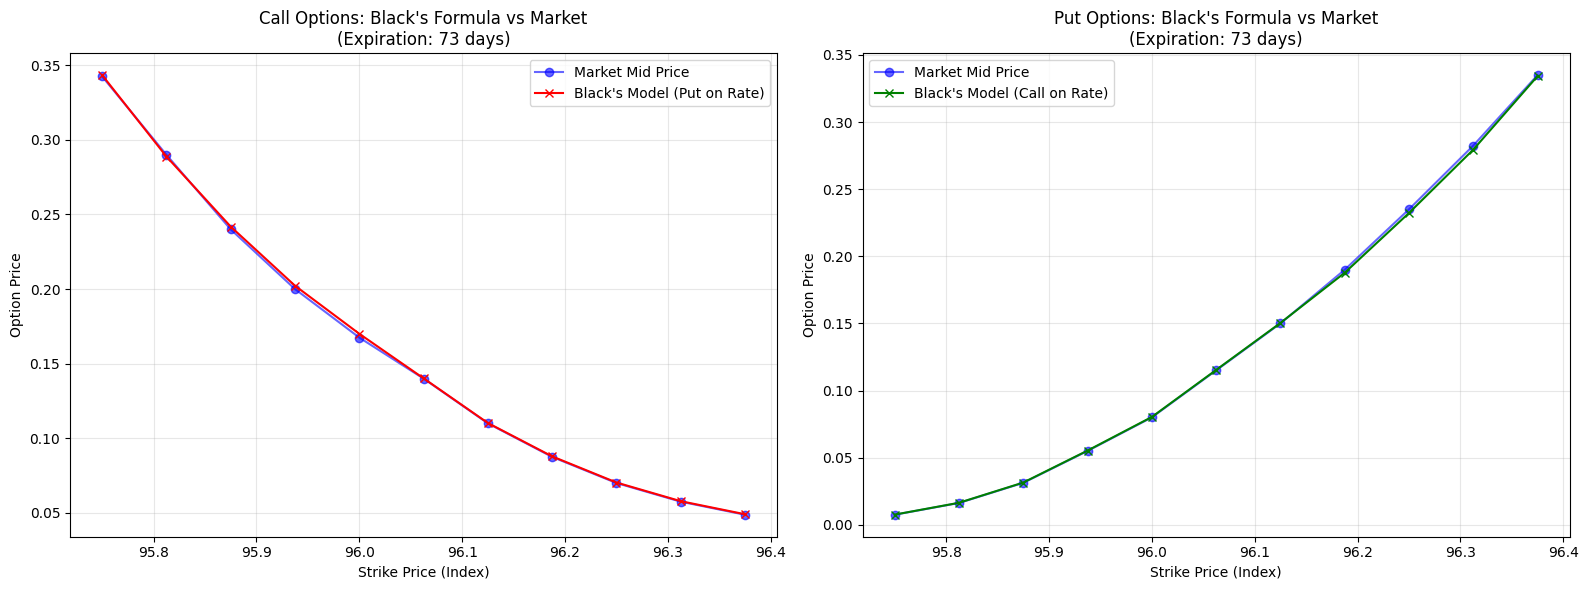

In [4]:
# Black's Formula for Calls on Rates
def black_call(F, K, T, r, sigma):
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return np.exp(-r * T) * (F * norm.cdf(d1) - K * norm.cdf(d2))

# Convert Futures Prices into rate for every row.
calls_calc['F_rate'] = (100 - F_price) / 100.0
calls_calc['K_rate'] = (100 - calls_calc['strike price']) / 100.0

# Convert days to expiration into fraction of a year.
calls_calc['T_years'] = calls_calc['days to expiration'] / 365.0

# Calculate model price for each call: price a Put on Rates using Black's formula.
calls_calc['model_price'] = calls_calc.apply(
    lambda row: black_put(
        row['F_rate'],
        row['K_rate'],
        row['T_years'],
        float(row['finance rate']),
        float(row['implied vol'])
    ) * 100, axis=1
)

# Convert Futures Prices into rate for every row.
puts_calc = puts.copy()
puts_calc['F_rate'] = (100 - F_price) / 100.0
puts_calc['K_rate'] = (100 - puts_calc['strike price']) / 100.0

# Convert days to expiration into fraction of a year.
puts_calc['T_years'] = puts_calc['days to expiration'] / 365.0

# Calculate model price for each put: price a Call on Rates using Black's formula.
puts_calc['model_price'] = puts_calc.apply(
    lambda row: black_call(
        row['F_rate'],
        row['K_rate'],
        row['T_years'],
        float(row['finance rate']),
        float(row['implied vol'])
    ) * 100, axis=1
)

# Plotting Call and Put Option Prices with Subplots, each with its own y-axis
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

ax_call = axs[0]
ax_call.plot(
    calls_calc['strike price'],
    (calls_calc['bid'] + calls_calc['ask']) / 2,
    color='blue', marker='o', alpha=0.6, label='Market Mid Price'
)
ax_call.plot(
    calls_calc['strike price'],
    calls_calc['model_price'],
    color='red', marker='x', label="Black's Model (Put on Rate)"
)
ax_call.set_title(f"Call Options: Black's Formula vs Market\n(Expiration: {calls_calc['days to expiration'].iloc[0]} days)")
ax_call.set_xlabel('Strike Price (Index)')
ax_call.set_ylabel('Option Price')
ax_call.legend()
ax_call.grid(True, alpha=0.3)

ax_put = axs[1]
ax_put.plot(
    puts_calc['strike price'],
    (puts_calc['bid'] + puts_calc['ask']) / 2,
    color='blue', marker='o', alpha=0.6, label='Market Mid Price'
)
ax_put.plot(
    puts_calc['strike price'],
    puts_calc['model_price'],
    color='green', marker='x', label="Black's Model (Call on Rate)"
)
ax_put.set_title(f"Put Options: Black's Formula vs Market\n(Expiration: {puts_calc['days to expiration'].iloc[0]} days)")
ax_put.set_xlabel('Strike Price (Index)')
ax_put.set_ylabel('Option Price')
ax_put.legend()
ax_put.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 1.3 Discrepancies in American and European Exercise

**Reasons for Discrepancies:**

 The model fit in Section 1.2 is very close (because we are feeding back the market's own implied volatility). Small differences we see can arise from several factors:

- **Exercise Style (American vs European):**
  - The Black-76 formula prices European options.
  - SOFR futures options, however, are American (exercisable at any time before expiration).
  - The theoretical price for an American option is always $\geq$ the European equivalent, because of the added flexibility for early exercise.
  - For short-term interest rate options such as SOFR futures, the premium associated with the right for early exercise (the "American premium") is typically very small, but not zero.
  - As a result, market prices for the American options tend to be slightly higher compared to the Black's model (European) price.

- **Market Microstructure:**
  - Options trade in discrete price increments ("ticks"; e.g., 0.0025 or 0.01).
  - The model produces a continuous float value, whereas market prices are always rounded to the nearest tick.

- **Settlement Timing:**
  - The "price" column likely reflects a settlement or last trade price, while implied volatility may reflect a mid-market quote.
  - Any slight timing mismatches between the futures price $F$ and the option price will create a residual error.


**How significant is the American nature of the exercise?**

For standard exchange-traded interest rate futures options such as those on SOFR, the impact of American-style exercise is generally very minimal and often only a fraction of a tick for out-of-the-money and at-the-money options, especially when the interest rate for discounting is low and the option is not deeply in-the-money. This is because it is rarely optimal to exercise early.

> The difference between American and European option prices for options on futures is very small. Any observed discrepancies are typically due far more to market microstructure (tick size, bid/ask spread) or timing mismatches than to exercise style.

### 1.4 How is implied vol quoted? Compute 60-day rolling SOFR volatility

 **What the chain’s `implied vol` corresponds to:**
- In a Black (1976) futures-option framework, $\sigma$ is the **annualized volatility of the futures price** under a lognormal assumption (i.e., volatility of log returns of $F$).
- For SOFR futures, the futures price is $F \approx 100 - R$, where $R$ is the underlying rate in percent.
- So the implied vol is naturally tied to **percent changes in the futures price**, not day-over-day level changes in the SOFR rate.

 Below, we compute two historical 60-business-day rolling vols:
 1) Log-return vol of $F_t = 100 - \text{SOFR}_t$
 2) Vol of daily SOFR changes


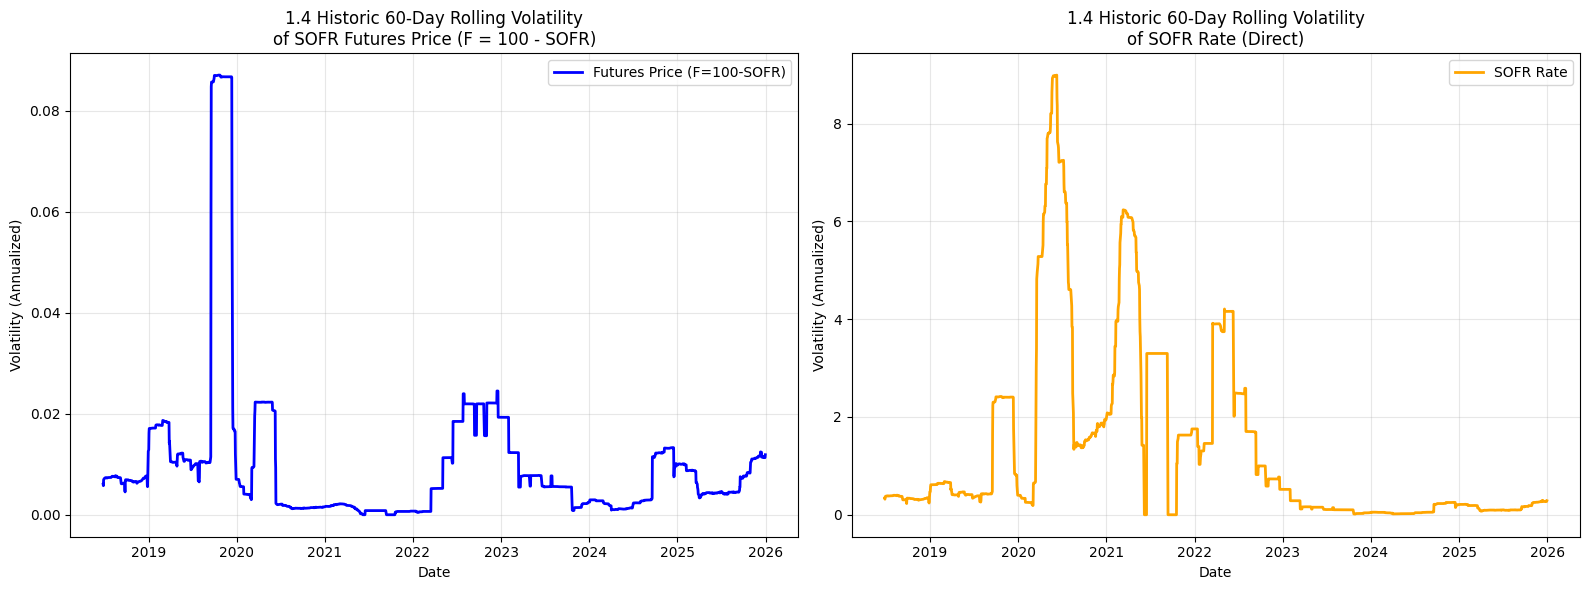

,Latest 60-day Rolling Vol (Futures Price),Latest 60-day Rolling Vol (SOFR Rate)
2025-12-31 00:00:00,0.011879,0.286402


In [18]:
# Copy and organize historical reference rate data
df_hist = historical_ref_rates.copy()
df_hist['date'] = pd.to_datetime(df_hist['date'])
df_hist = df_hist.set_index('date').sort_index()

# Select non-null SOFR rates
sofr_rates = df_hist['SOFR'].dropna()

# Convert SOFR rates to futures price
f = 100 - sofr_rates

# Calculate log daily returns
log_returns_f = np.log(f / f.shift(1))

# Calculate log daily returns
log_returns_sofr = np.log(sofr_rates / sofr_rates.shift(1))

# Compute annualized 60-day rolling volatility
rolling_vol_60d_f = log_returns_f.rolling(window=60).std() * np.sqrt(252)
rolling_vol_60d_sofr = log_returns_sofr.rolling(window=60).std() * np.sqrt(252)

# Visualization of both rolling volatility histories in two subplots,
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Futures price rolling vol
ax_f = axs[0]
ax_f.plot(
    rolling_vol_60d_f.index, rolling_vol_60d_f,
    color='blue', linewidth=2, label='Futures Price (F=100-SOFR)'
)
ax_f.set_title("1.4 Historic 60-Day Rolling Volatility\nof SOFR Futures Price (F = 100 - SOFR)")
ax_f.set_xlabel('Date')
ax_f.set_ylabel('Volatility (Annualized)')
ax_f.legend()
ax_f.grid(True, alpha=0.3)

# SOFR rate rolling vol
ax_r = axs[1]
ax_r.plot(
    rolling_vol_60d_sofr.index, rolling_vol_60d_sofr,
    color='orange', linewidth=2, label='SOFR Rate'
)
ax_r.set_title("1.4 Historic 60-Day Rolling Volatility\nof SOFR Rate (Direct)")
ax_r.set_xlabel('Date')
ax_r.set_ylabel('Volatility (Annualized)')
ax_r.legend()
ax_r.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display the most recent rolling volatility for both
latest_vols_df = pd.DataFrame({
    "Latest 60-day Rolling Vol (Futures Price)": [rolling_vol_60d_f.iloc[-1]],
    "Latest 60-day Rolling Vol (SOFR Rate)": [rolling_vol_60d_sofr.iloc[-1]]
}, index=[rolling_vol_60d_f.index[-1]])
latest_vols_df = latest_vols_df.style.set_caption("Most Recent 60-Day Rolling Annualized Volatility: Futures Price and SOFR Rate")
latest_vols_df

### 1.5 Open Interest Analysis
 
**Rationale:**  
We visualize the Open Interest (OI) for both Calls and Puts, and then calculate the Total Notional Open Interest.

- **Contract Size:** 2500 (representing \$2,500 per index point)
- **Futures Price:** $F$
- **Notional Formula:**  
   $\text{Total Notional} = \sum\left(\text{Open Interest} \times \text{Futures Price} \times \text{Contract Size}\right)$
 
*Note: While some definitions use Strike Price, we use the current underlying futures price which is the standard for estimating current market exposure.*

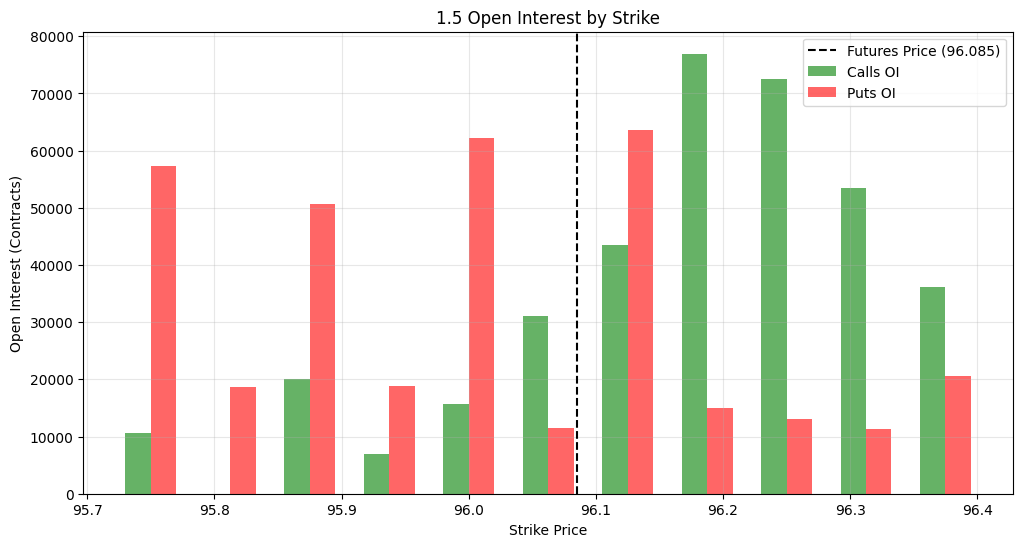

,Value
Total Contracts Open,"709,775"
Contract Size,"2,500"
Current Futures Price,96.0850
Total Notional Value ($),"$170,496,827,187.50"


In [5]:
# Get unique sorted strikes across calls and puts
strikes = sorted(set(calls['strike price']).union(puts['strike price']))

# Reindex open interest for calls and puts to all strikes
calls_oi = calls.set_index('strike price').reindex(strikes)['open int']
puts_oi = puts.set_index('strike price').reindex(strikes)['open int']

bar_width = 0.02

# Plot open interest for calls and puts by strike
plt.figure(figsize=(12, 6))
plt.bar([s - bar_width/2 for s in strikes], calls_oi,
        width=bar_width, label='Calls OI', color='green', alpha=0.6)
plt.bar([s + bar_width/2 for s in strikes], puts_oi,
        width=bar_width, label='Puts OI', color='red', alpha=0.6)
plt.axvline(x=F_price, color='black', linestyle='--', label=f'Futures Price ({F_price:.3f})')
plt.title('1.5 Open Interest by Strike')
plt.xlabel('Strike Price')
plt.ylabel('Open Interest (Contracts)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Combine both calls and puts data for total OI calculation
chain_all = pd.concat([calls, puts], ignore_index=True)

# Ensure open interest is numeric and fill NaN with 0
chain_all['open int'] = pd.to_numeric(chain_all['open int'], errors='coerce').fillna(0)

# Pull contract size (should be the same for all rows)
contract_size = float(chain_all['option contract size'].iloc[0])

# Sum total open interest across all strikes (calls + puts)
total_oi = chain_all['open int'].sum()

# Compute total notional market value
total_notional = total_oi * contract_size * F_price

# Display results as a DataFrame
summary_df = pd.DataFrame({
    "Value": [
        f"{total_oi:,.0f}",
        f"{contract_size:,.0f}",
        f"{F_price:.4f}",
        f"${total_notional:,.2f}"
    ]
}, index=[
    "Total Contracts Open",
    "Contract Size",
    "Current Futures Price",
    "Total Notional Value ($)"
])

summary_df.style.set_caption("1.5 Total Notional Open Interest")